### 4. Weak Instruments

(1) Construct a data-generating process dgp which takes as arguments (n, β, π) and returns a triple (y, x, Z) of n observations.

In [67]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t
import matplotlib.pyplot as plt 

In [68]:
def dgp(n, beta, pi):
    # Generate Z based on l (length of coefficient vector inputted for pi)
    l = len(pi)
    Z = np.random.randn(n, l)
    
    # Generate v (error term regressing x on Z)
    v = np.random.randn(n)
    
    # Generate x
    x = Z.dot(pi) + v
    
    # Generate u (error term for y)
    u = np.random.randn(n)
    
    # Generate y
    y = beta * x + u
    
    return y, x, Z

(2) Use the dgp function you’ve constructed to explore IV (2SLS) estimates of β as a function of π when l = 1 using a Monte Carlo approach, assuming homoskedastic errors.

In [69]:
# Run dgp function to test
y, x, Z = dgp(1000, 2, np.array([0.75]))

# Print the shapes of generated arrays
print("Shape of y:", y.shape)
print("Shape of x:", x.shape)
print("Shape of Z:", Z.shape)

Shape of y: (1000,)
Shape of x: (1000,)
Shape of Z: (1000, 1)


(a) Write a function two_sls which takes as arguments (y, x, Z) and returns two-stage least squares estimates of β and the standard error of the estimate.

In [70]:
def two_sls(y, x, Z):
    # First stage regression
    first_stage_model = sm.OLS(x, Z).fit()
    # Store fitted values
    x_hat = first_stage_model.predict()

    # Second stage regression
    second_stage_model = sm.OLS(y, sm.add_constant(x_hat)).fit()

    # Pull coefficient estimate of beta hat and standard error
    beta_hat = second_stage_model.params[1]
    se = second_stage_model.bse[1]

    return beta_hat, se

# Set the seed for reproducibility
np.random.seed(1)

# Example usage
beta_hat, se = two_sls(y, x, Z)

# Print estimated coefficient and standard error
print("Estimated coefficient (beta_hat):", beta_hat)
print("Standard error of the estimate (SE):", se)

Estimated coefficient (beta_hat): 1.9669840903343716
Standard error of the estimate (SE): 0.09955749714461369


Note that the standard errors found above are likely to be inflated because the estimated endogenous variable(s) in the second stage are based on the first-stage estimates.The predicted values used in the second stage are estimates themselves and are subject to sampling variability. As a result, any imprecision in the first stage will get carried into the second stage.

b) Taking β = π = 1, use repeated draws from dgp to check the bias, and precision of the two_sls estimator, as well as the size and power of a t-test of the hypothesis that β = 0. Discuss. Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

In [71]:
def monte_carlo_simulation(n_simulations, n, beta, pi):
    # Store draws in results list
    results = []
    for i in range(n_simulations):
        # Run simulation
        y, x, Z = dgp(n, beta, pi)
        
        # Pull beta_hat and se for each draw
        beta_hat, se = two_sls(y, x, Z)
        
        # calculate t-stat and p-value
        # null is 0
        t_stat = (beta_hat - 0) / se
        p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
        # significance level is 0.05
        reject_null = 1 if p_value < 0.05 else 0
        results.append({'beta_hat': beta_hat, 'se': se, 't-stat': t_stat,
                        'p-value': p_value, 'reject_null': reject_null})
        
    return pd.DataFrame(results)

In [72]:
# Define Parameters
# Re-run dgp function assuming β = π = 1
n_simulations = 1000
n = 1000
beta = 1
pi = np.array([1])

# Set the seed for reproducibility
np.random.seed(1)

# Run Monte Carlo simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi)

In [73]:
# Calculate bias and precision of 2SLS estimator
# bias: E[beta_hat] - beta 
bias = simulation_results['beta_hat'].mean() - beta
# precision: sqrt [var(beta_hat)/n]
precision = simulation_results['beta_hat'].std()/np.sqrt(len(simulation_results['beta_hat']))

# Calculate size and power of t-test
# power: probability of correctly rejecting a null hypothesis when false
power = simulation_results['reject_null'].mean() # note 100% of tests are rejected, without rounding
size = 1 - power ### is the size just 0.05? 

# Calculate coverage probability of 95% confidence interval 
# check if true B is included in confidence interval (check if lower bound of CI is below B, and upper bound is above B)
ci_coverage = simulation_results[(simulation_results['beta_hat'] - 1.96 * simulation_results['se'] < beta) &
                                  (simulation_results['beta_hat'] + 1.96 * simulation_results['se'] > beta)].shape[0] / n_simulations

In [74]:
print("Bias of 2SLS estimator:", bias)
print("Precision of 2SLS estimator:", precision)
print("Power of t-test:", power)
print("Size of t-test:", size)
print("Coverage probability of 95% CI:", ci_coverage)

Bias of 2SLS estimator: -0.0013769816865324414
Precision of 2SLS estimator: 0.000989867802182021
Power of t-test: 1.0
Size of t-test: 0.0
Coverage probability of 95% CI: 0.994


Yes, the 95% confidence intervals constructed from the 2SLS estimator cover over 95% of my Monte Carlo draws. 

(c) Taking β = 1, but allowing π ∈ [0, 1] again evaluate the bias and precision of the estimator, and the size and power of a t-test. The Z instrument is “weak” when π is “close” to zero. Comment on how a weak instrument affects two- stage least squares estimators.

In [75]:
# Re-Define Parameters
# Re-run dgp function assuming β = 1 and allowing π ∈ [0, 1]
# For each draw the value of pi is different?
n_simulations = 1000
n = 1000
beta = 1
# Create random value in between 0 and 1 
pi = np.array([np.random.uniform(0, 1)])

# Set the seed for reproducibility
np.random.seed(1)

print("Random value of pi selected between 0 and 1 (as array):", pi)

Random value of pi selected between 0 and 1 (as array): [0.12185229]


In [76]:
# Re-Run Monte Carlo simulation with randomly selected value of pi 
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi)

In [77]:
# Calculate bias and precision of 2SLS estimator
# bias: E[beta_hat] - beta 
bias = simulation_results['beta_hat'].mean() - beta
# precision: sqrt [var(beta_hat)/n]
precision = simulation_results['beta_hat'].std()/np.sqrt(len(simulation_results['beta_hat']))

# Calculate size and power of t-test
# power: probability of correctly rejecting a null hypothesis when false
power = simulation_results['reject_null'].mean() # note 100% of tests are rejected, without rounding
size = 1 - power ### is the size just 0.05? 

# Calculate coverage probability of 95% confidence interval 
# check if true B is included in confidence interval (check if lower bound of CI is below B, and upper bound is above B)
ci_coverage = simulation_results[(simulation_results['beta_hat'] - 1.96 * simulation_results['se'] < beta) &
                                  (simulation_results['beta_hat'] + 1.96 * simulation_results['se'] > beta)].shape[0] / n_simulations

In [78]:
print("Bias of 2SLS estimator:", bias)
print("Precision of 2SLS estimator:", precision)
print("Power of t-test:", power)
print("Size of t-test:", size)
print("Coverage probability of 95% CI:", ci_coverage)

Bias of 2SLS estimator: -0.013327609614108504
Precision of 2SLS estimator: 0.010213950276119644
Power of t-test: 0.763
Size of t-test: 0.237
Coverage probability of 95% CI: 0.994


When pi is "close" to zero, Z is considered a weak instrument, as the instrument has little explanatory power in predicting X. This can lead to biased inference in estimating the causal relationship between x and y through inflated standard errors. With a weak instrument, the power of our t-test decreased notably. The figure below shows the relationship between beta-hat and pi. As pi increases, our estimate for beta hat becomes less noisy.

In [79]:
# Figure on how relationship between beta hat and pi
def monte_carlo_simulation(n_simulations, n, beta, pi_range):
    results = []
    for pi_value in pi_range:
        pi = np.array([pi_value])
        for _ in range(n_simulations):
            y, x, Z = dgp(n, beta, pi)
            beta_hat, se = two_sls(y, x, Z)
            t_stat = (beta_hat - 0) / se
            p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
            reject_null = 1 if p_value < 0.05 else 0
            results.append({'pi': pi_value, 'beta_hat': beta_hat})
    return pd.DataFrame(results)

# Parameters
n_simulations = 1000
n = 1000
beta = 1
pi_range = np.random.uniform(0, 1, size=1000)  # Generating 1000 random values for pi

# Run the simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi_range)

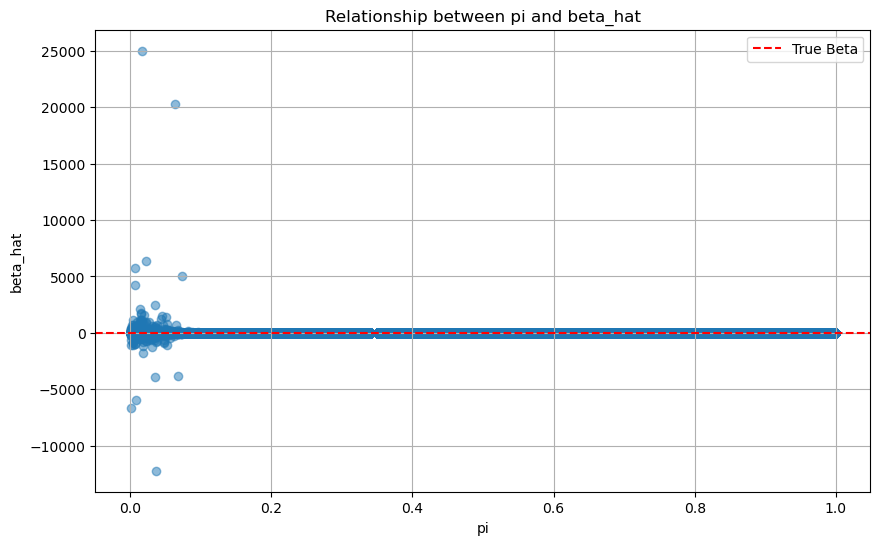

In [80]:
import matplotlib.pyplot as plt 

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(simulation_results['pi'], simulation_results['beta_hat'], alpha=0.5)
plt.axhline(y=beta, color='r', linestyle='--', label='True Beta')
plt.xlabel('pi')
plt.ylabel('beta_hat')
plt.title('Relationship between pi and beta_hat')
plt.legend()
plt.grid(True)
plt.show()

(3) Now consider another “weak” instruments problem. Consider the sequence {1,1/2,1/4,1/8,...}. Let l = 1,2,3,..., and for a particular value of l let the vector of parameters πl consist of the first l elements of the sequence. Thus, your dgp should now return Z we can treat as an n × l matrix, with successive columns of Z increasingly “weak” instruments.

In [81]:
def dgp(n, beta, l):
    # Define the sequence
    sequence = np.array([1 / (2**i) for i in range(1, l + 1)])
    
    # Generate Z based on the input l / sequence denoted above
    Z = np.zeros((n, l))
    
    for i in range(l):
        Z[:, i] = np.random.randn(n) * sequence[i]
    
    # Generate v (error term regressing x on Z)
    v = np.random.randn(n)
    
    # Generate x
    # sum of all IVs and error term for each observation
    x = Z.sum(axis=1) + v
    
    # Generate u (error term for y)
    u = np.random.randn(n)
    
    # Generate y
    y = beta * x + u
    
    return y, x, Z

(a) Taking β = 1, but allow l to increase (l = 1, 2, ...). Note that for l > 1 this is now an “overidentified” estimator. Describe the bias and precision of the estimator, and the size and power of a t-test. Compare with the case of l = 1 and π = 1.


In [82]:
def monte_carlo_simulation(n_simulations, n, beta, l_values):
    results = {'bias': [], 'precision': [], 'reject_rate': []}

    for l in l_values:
        bias_list = []
        precision_list = []
        reject_rate_list = []
        
        for _ in range(n_simulations):
            # Run simulation
            y, x, Z = dgp(n, beta, l)
            # First stage regression
            first_stage_model = sm.OLS(x, Z).fit()
            # Store fitted values
            x_hat = first_stage_model.predict()
            # Second stage regression
            second_stage_model = sm.OLS(y, sm.add_constant(x_hat)).fit()
            # Pull coefficient estimate of beta hat and standard error
            beta_hat = second_stage_model.params[1]
            se = second_stage_model.bse[1]
            # Calculate t-stat and p-value
            t_stat = beta_hat / se
            p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
            # Calculate reject_null
            reject_null = 1 if p_value < 0.05 else 0
            # Calculate bias
            bias = beta_hat - beta
            # Calculate precision
            precision = se / np.sqrt(n)
            
            bias_list.append(bias)
            precision_list.append(precision)
            reject_rate_list.append(reject_null)
        
        results['bias'].append(np.mean(bias_list))
        results['precision'].append(np.mean(precision_list))
        results['reject_rate'].append(np.mean(reject_rate_list))
        
    return results

# Set the seed for reproducibility
np.random.seed(1)

# Parameters
n_simulations = 1000
n = 1000
beta = 2
l_values = range(1, 20)  # Varying values of l from 1 to 20

# Run simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, l_values)

In [83]:
# Print power
# need to still add sign?
power = np.mean(simulation_results['reject_rate'])
print("Power:", mean_reject_rate)

Power: 1.0


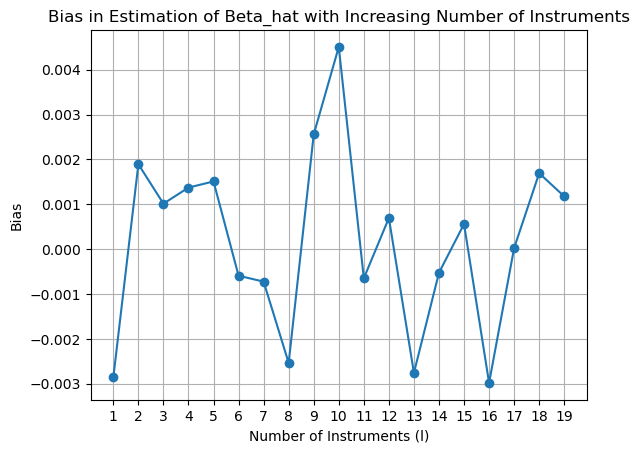

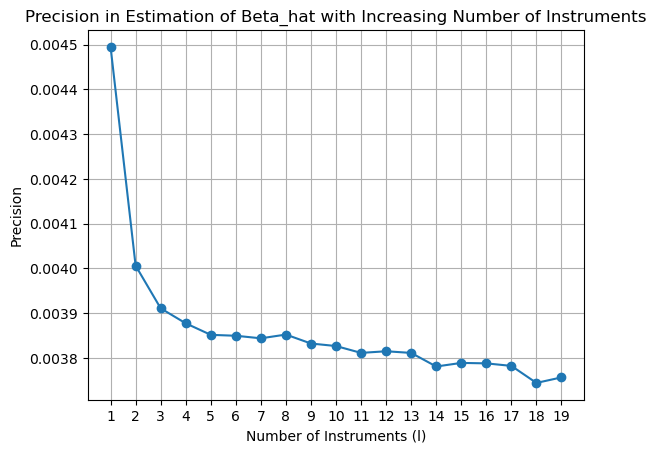

In [84]:
# Plotting bias
plt.plot(l_values, simulation_results['bias'], marker='o')
plt.xticks(l_values)
plt.xlabel('Number of Instruments (l)')
plt.ylabel('Bias')
plt.title('Bias in Estimation of Beta_hat with Increasing Number of Instruments')
plt.grid(True)
plt.show()

# Plotting precision
plt.plot(l_values, simulation_results['precision'], marker='o')
plt.xticks(l_values)
plt.xlabel('Number of Instruments (l)')
plt.ylabel('Precision')
plt.title('Precision in Estimation of Beta_hat with Increasing Number of Instruments')
plt.grid(True)
plt.show()


(b) What can you say about the optimal number of instruments (choice of l) in this case?

Increasing the number of instruments in this case does not yield significant improvements in bias reduction, and the bias becomes (as seen in the figure) noisier due to multicollinearity between instruments. We also see precision decrease as add weak instruments, especially evident in the drop observed from 1 to 2 instruments. 